In [48]:
import librosa
import matplotlib.pyplot as plt

def plot_waveform(audio_path):
  y, sr = librosa.load(audio_path, sr=None)
  plt.figure(figsize=(14, 4))
  plt.plot(y)
  plt.title('Raw Waveform')
  plt.xlabel('Sample')
  plt.ylabel('Amplitude')
  plt.show()

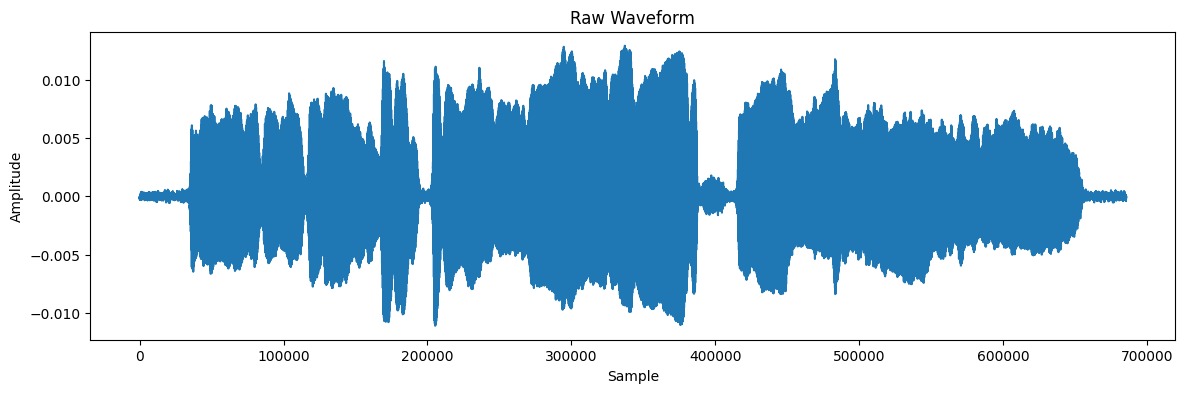

In [49]:
plot_waveform("D:/belajar/audio/vad/datasets/FULL/male1/scales/breathy/m1_scales_breathy_i.wav")

In [44]:
import logging
from pathlib import Path
from typing import Optional

import librosa
import numpy as np
from scipy.ndimage import binary_closing, binary_dilation

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

def label_singing_vocals_heuristically(
    audio_path: Path,
    frame_hop_length: int = 160,
    sample_rate: int = 16000,
    *,
    # --- Tunables with improved defaults for singing -------------
    energy_rms_frame_ms: int = 25,
    energy_rms_hop_ms: int = 10,
    energy_thresh_percentile: int = 5,      # Lower to 5% to catch very quiet singing
    pitch_fmin: float = librosa.note_to_hz("A2"),
    pitch_fmax: float = librosa.note_to_hz("C6"),
    voiced_prob_threshold: float = 0.2,    # Even more permissive threshold
    min_segment_duration_ms: int = 60,      # Shorter to catch brief onsets
    expand_segment_ms: int = 100,           # Expand more to connect segments
    smoothing_filter_size: int = 7,
    apply_normalization: bool = True,
    apply_preemphasis: bool = True, 
    use_alternative_method: bool = True,
    detect_quiet_beginnings: bool = True,   # NEW: special handling for quiet starts
) -> np.ndarray:
    """Return frame‑level 0/1 labels indicating probable singing voice.

    Enhanced for singing voice detection with normalization, pre-emphasis,
    and alternative detection for subtle singing passages.
    """

    # ------------------------------------------------------------------
    # 1. Load & pre‑process audio (stereo → mono, resample)
    # ------------------------------------------------------------------
    try:
        y, sr_orig = librosa.load(audio_path, sr=None, mono=False)
    except Exception as exc:
        logger.error("Failed to read %s: %s", audio_path, exc)
        return np.zeros(1, dtype=np.float32)

    if y.ndim == 2:  # stereo → mono while avoiding phase cancellation issues
        y = librosa.to_mono(y)
    if sr_orig != sample_rate:
        y = librosa.resample(y, orig_sr=sr_orig, target_sr=sample_rate)

    if y.size == 0:  # empty file guard
        return np.zeros(1, dtype=np.float32)
    
    # NEW: Normalize audio to improve consistency
    if apply_normalization and np.abs(y).max() > 0:
        y = y / np.abs(y).max() * 0.9  # Scale to 90% of max amplitude
    
    # ------------------------------------------------------------------
    # 2. Feature extraction (Energy + Pitch) at a *feature* rate
    # ------------------------------------------------------------------
    rms_frame_len = int(sample_rate * energy_rms_frame_ms / 1000)
    rms_hop_len = int(sample_rate * energy_rms_hop_ms / 1000)
    
    # NEW: Apply pre-emphasis to boost high frequencies if enabled
    y_for_energy = y
    if apply_preemphasis:
        y_for_energy = librosa.effects.preemphasis(y, coef=0.97)
    
    # Calculate RMS energy on possibly pre-emphasized signal
    rms_energy = librosa.feature.rms(
        y=y_for_energy, 
        frame_length=rms_frame_len,
        hop_length=rms_hop_len, 
        center=True
    )[0]

    # Calculate pitch on original (not pre-emphasized) signal
    f0, voiced_flag, voiced_prob = librosa.pyin(
        y,  # Use original signal for pitch
        fmin=pitch_fmin,
        fmax=pitch_fmax,
        sr=sample_rate,
        frame_length=rms_frame_len,
        hop_length=rms_hop_len,
        center=True,
        fill_na=0.0,
    )

    # Align arrays length if pyin pads one extra frame
    n_feat_frames = min(len(rms_energy), len(voiced_prob))
    rms_energy = rms_energy[:n_feat_frames]
    voiced_prob = voiced_prob[:n_feat_frames]
    
    # ------------------------------------------------------------------
    # 3. Initial decision rule (energy + voicing)
    # ------------------------------------------------------------------
    energy_threshold = np.percentile(rms_energy, energy_thresh_percentile)
    energy_threshold = max(energy_threshold, 1e-5)  # protect against zero

    is_energetic = rms_energy > energy_threshold
    is_voiced = voiced_prob > voiced_prob_threshold
    speech_mask = (is_energetic & is_voiced).astype(np.uint8)
    
    # New block to add near line 118 in your function:
    # Further enhancement for low/quiet singing specifically
    if use_alternative_method:
        # [your existing code]
        
        # NEW: Additional pass specifically for low notes (which may have good voicing confidence but low energy)
        low_notes_mask = np.logical_and(
            voiced_prob > 0.3,  # Even more permissive for low notes
            f0 < librosa.note_to_hz("E3")  # Focus on low notes
        ).astype(np.uint8)
        
        # Add low notes to our speech mask
        speech_mask = np.logical_or(speech_mask, low_notes_mask).astype(np.uint8)
        
        # NEW: Special handling for extremely quiet singing with some pitch evidence
        # This is especially important for the beginnings of notes or quiet sustains
        if detect_quiet_beginnings:
            # Find regions with ANY detectable pitch (very permissive)
            any_pitch_evidence = voiced_prob > 0.15
            
            # Find regions with minimal energy (above absolute noise floor)
            minimal_energy = rms_energy > (np.max(rms_energy) * 0.02)  # Just 1% of max
            
            # Combine for extremely subtle singing detection
            quiet_singing_mask = np.logical_and(
                any_pitch_evidence, 
                minimal_energy
            ).astype(np.uint8)
            
            # Only add short segments (for safety - to avoid false positives)
            # This looks for short segments that might be note beginnings
            quiet_diff = np.diff(np.concatenate(([0], quiet_singing_mask, [0])))
            quiet_starts = np.where(quiet_diff == 1)[0]
            quiet_ends = np.where(quiet_diff == -1)[0]
            
            # Target very short segments for special protection (likely note beginnings)
            very_short_mask = np.zeros_like(quiet_singing_mask)
            for s, e in zip(quiet_starts, quiet_ends):
                segment_len = e - s
                if segment_len > 0 and segment_len < 30:  # Very short segments only
                    very_short_mask[s:e] = 1
            
            # Add these protected quiet beginnings
            speech_mask = np.logical_or(speech_mask, very_short_mask).astype(np.uint8)

    # ------------------------------------------------------------------
    # 4. Morphological smoothing & remove short blobs (unchanged)
    # ------------------------------------------------------------------
    if smoothing_filter_size % 2 == 0:
        smoothing_filter_size += 1  # ensure odd

    speech_mask = binary_closing(
        speech_mask,
        structure=np.ones(smoothing_filter_size, dtype=np.uint8),
    ).astype(np.uint8)

    # Remove blobs shorter than minimum length
    min_seg_frames = int(np.round(min_segment_duration_ms / 1000 * sample_rate / rms_hop_len))
    if min_seg_frames > 1:
        diff = np.diff(np.concatenate(([0], speech_mask, [0])))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        for s, e in zip(starts, ends):
            if (e - s) < min_seg_frames:
                speech_mask[s:e] = 0

    # Expand segments to catch onsets/offsets
    if expand_segment_ms > 0 and speech_mask.any():
        expand_frames = int(np.round(expand_segment_ms / 1000 * sample_rate / rms_hop_len))
        speech_mask = binary_dilation(
            speech_mask,
            structure=np.ones(expand_frames * 2 + 1, dtype=np.uint8),
        ).astype(np.uint8)

    # ------------------------------------------------------------------
    # 5. Resample labels to VAD frame rate (vectorised, unchanged)
    # ------------------------------------------------------------------
    feature_times = librosa.frames_to_time(np.arange(len(speech_mask)),
                                           sr=sample_rate, hop_length=rms_hop_len)
    num_out_frames = int(np.ceil(len(y) / frame_hop_length))
    if num_out_frames == 0:
        num_out_frames = 1

    vad_times = librosa.frames_to_time(np.arange(num_out_frames),
                                       sr=sample_rate, hop_length=frame_hop_length)

    out_labels = np.interp(vad_times, feature_times, speech_mask).astype(np.float32)
    out_labels = (out_labels >= 0.5).astype(np.float32)

    # ------------------------------------------------------------------
    logger.info(
        "Generated labels for %s | speech_ratio: %.2f%% | frames: %d",
        audio_path.name,
        100 * np.mean(out_labels),
        len(out_labels),
    )
    return out_labels

2025-05-26 23:39:24 - INFO - Generated labels for m1_scales_breathy_i.wav | speech_ratio: 88.62% | frames: 1555
2025-05-26 23:39:42 - INFO - Generated labels for m1_scales_breathy_i.wav | speech_ratio: 33.95% | frames: 1555


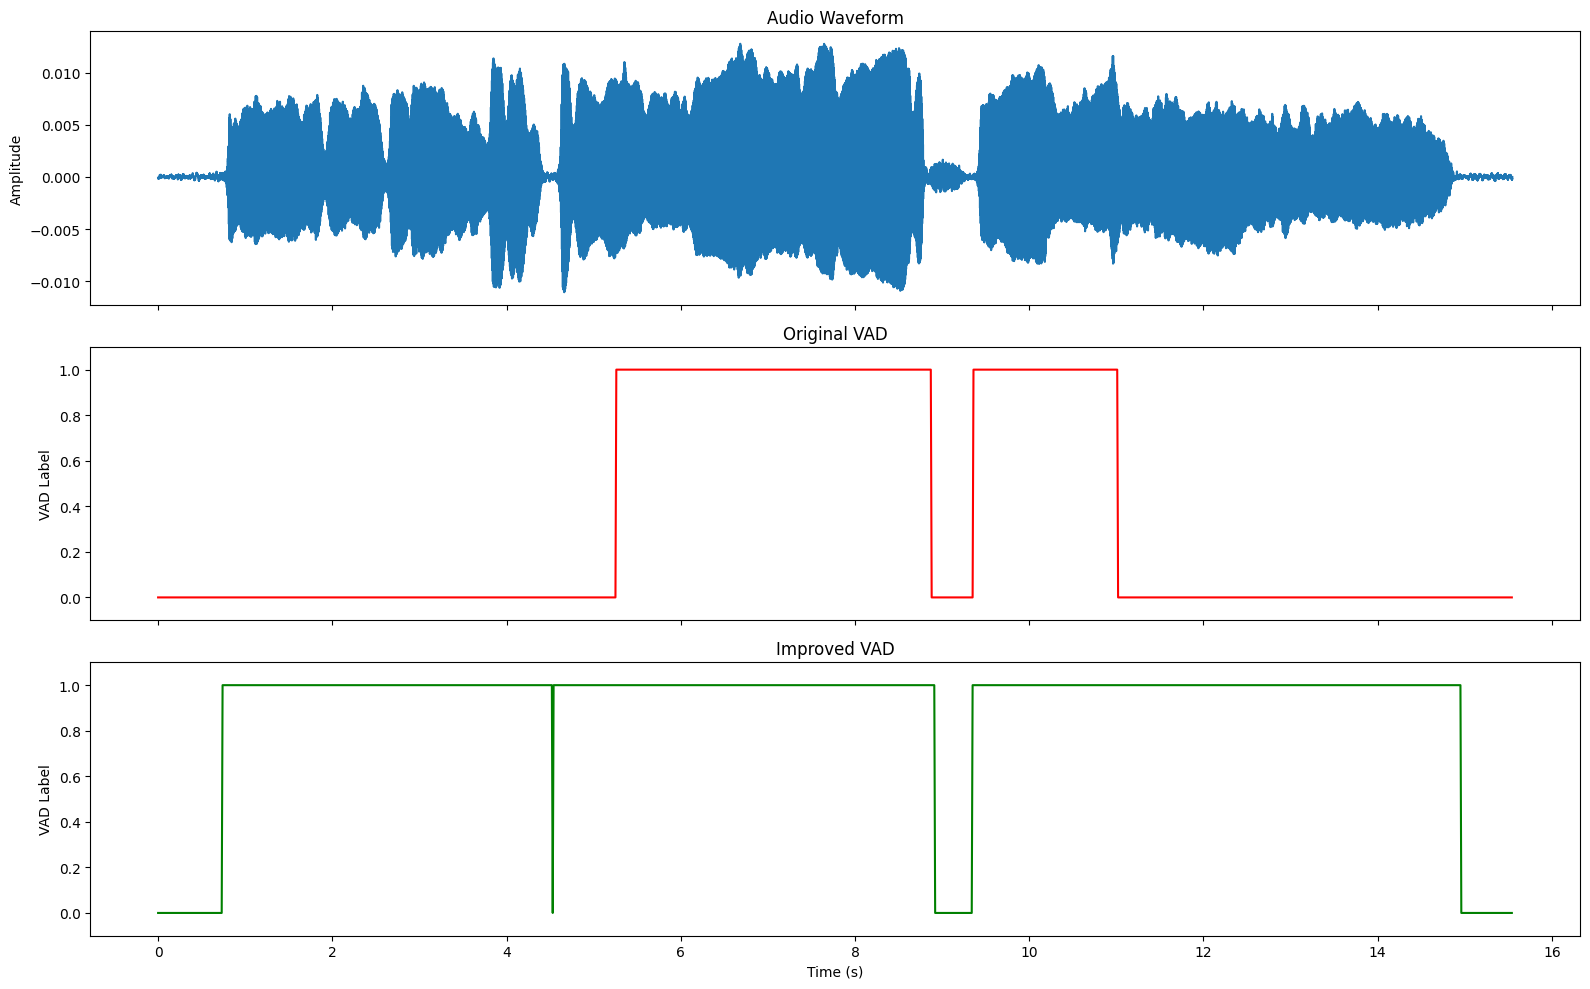

In [52]:
from pathlib import Path
import librosa
import matplotlib.pyplot as plt
import numpy as np

audio_path = Path("D:/belajar/audio/vad/datasets/FULL/male1/scales/breathy/m1_scales_breathy_i.wav")

# Get improved labels
improved_vad_labels = label_singing_vocals_heuristically(
    audio_path,
    # All the improvements enabled
    apply_normalization=True,
    apply_preemphasis=True,
    use_alternative_method=True,
)

# Original labels for comparison
original_vad_labels = label_singing_vocals_heuristically(
    audio_path,
    # Original parameters
    energy_thresh_percentile=30,
    voiced_prob_threshold=0.45,
    apply_normalization=False,
    apply_preemphasis=False,
    use_alternative_method=False
)

# Comparison visualization
y, sr = librosa.load(audio_path, sr=16000)
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# 1. Waveform
axes[0].plot(np.arange(len(y)) / sr, y)
axes[0].set_title("Audio Waveform")
axes[0].set_ylabel("Amplitude")

# 2. Original labels
vad_times = librosa.frames_to_time(np.arange(len(original_vad_labels)), sr=sr, hop_length=160)
axes[1].plot(vad_times, original_vad_labels, 'r')
axes[1].set_ylim([-0.1, 1.1])
axes[1].set_title("Original VAD")
axes[1].set_ylabel("VAD Label")

# 3. Improved labels
vad_times = librosa.frames_to_time(np.arange(len(improved_vad_labels)), sr=sr, hop_length=160)
axes[2].plot(vad_times, improved_vad_labels, 'g')
axes[2].set_ylim([-0.1, 1.1])
axes[2].set_title("Improved VAD")
axes[2].set_ylabel("VAD Label")
axes[2].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

2025-05-27 00:24:49 - INFO - Initializing Silero VAD model
2025-05-27 00:24:49 - INFO - Loading Silero VAD using pip package (recommended method)


2025-05-27 00:24:50 - INFO - Silero VAD model initialized successfully


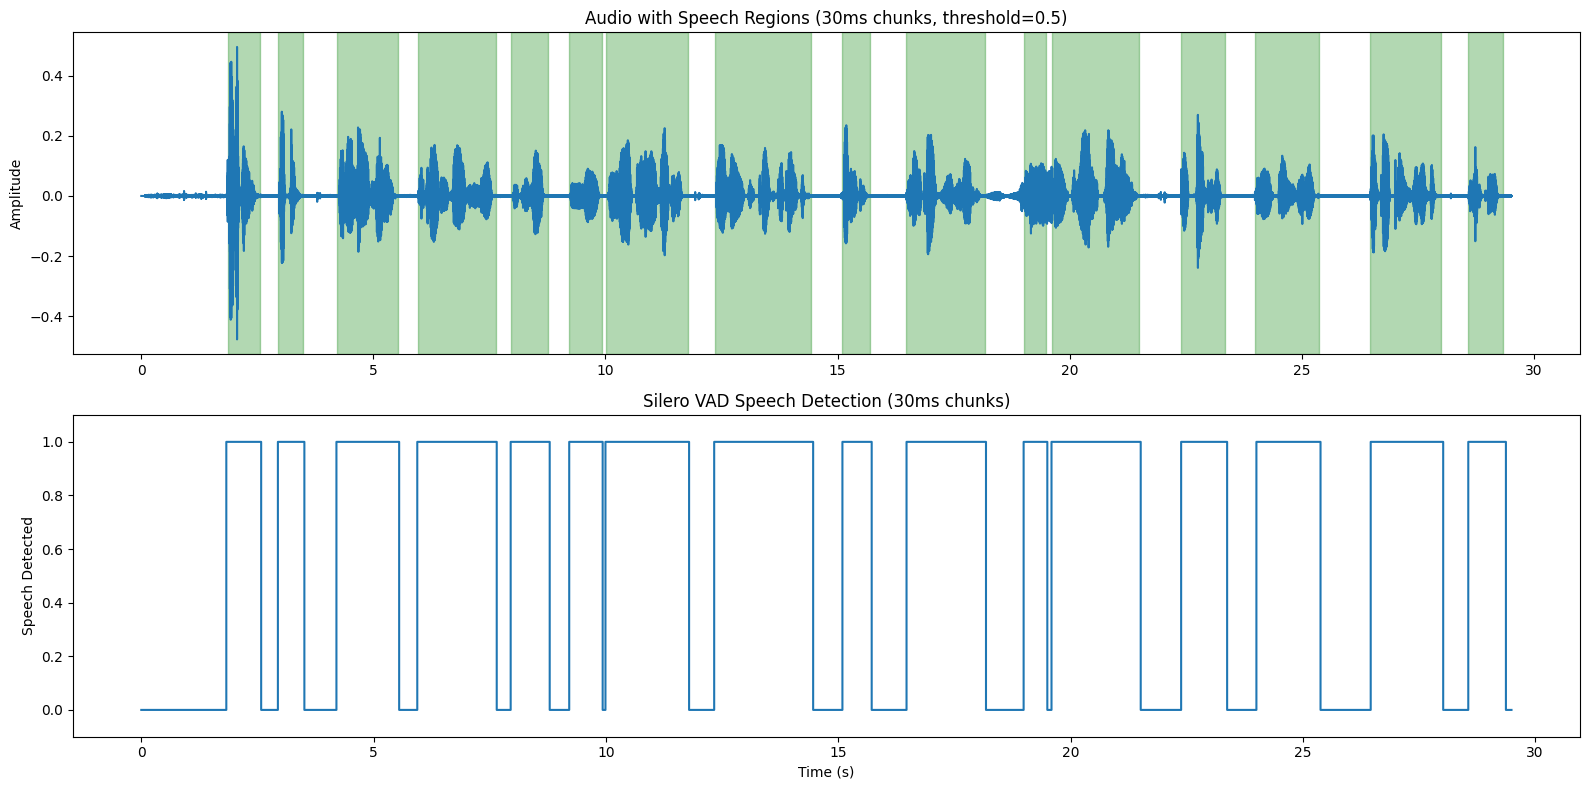

Audio length: 29.52 seconds
Speech detected: 18.85 seconds (63.8%)
Found 16 speech segments:
  Segment 1: 1.86s - 2.56s (duration: 0.70s)
  Segment 2: 2.95s - 3.49s (duration: 0.54s)
  Segment 3: 4.23s - 5.53s (duration: 1.31s)
  Segment 4: 5.95s - 7.65s (duration: 1.69s)
  Segment 5: 7.97s - 8.77s (duration: 0.80s)
  Segment 6: 9.22s - 9.92s (duration: 0.70s)
  Segment 7: 10.02s - 11.77s (duration: 1.76s)
  Segment 8: 12.35s - 14.43s (duration: 2.08s)
  Segment 9: 15.11s - 15.71s (duration: 0.60s)
  Segment 10: 16.48s - 18.17s (duration: 1.69s)
  Segment 11: 19.01s - 19.49s (duration: 0.48s)
  Segment 12: 19.62s - 21.50s (duration: 1.88s)
  Segment 13: 22.40s - 23.36s (duration: 0.96s)
  Segment 14: 24.00s - 25.37s (duration: 1.37s)
  Segment 15: 26.47s - 28.00s (duration: 1.53s)
  Segment 16: 28.58s - 29.34s (duration: 0.76s)


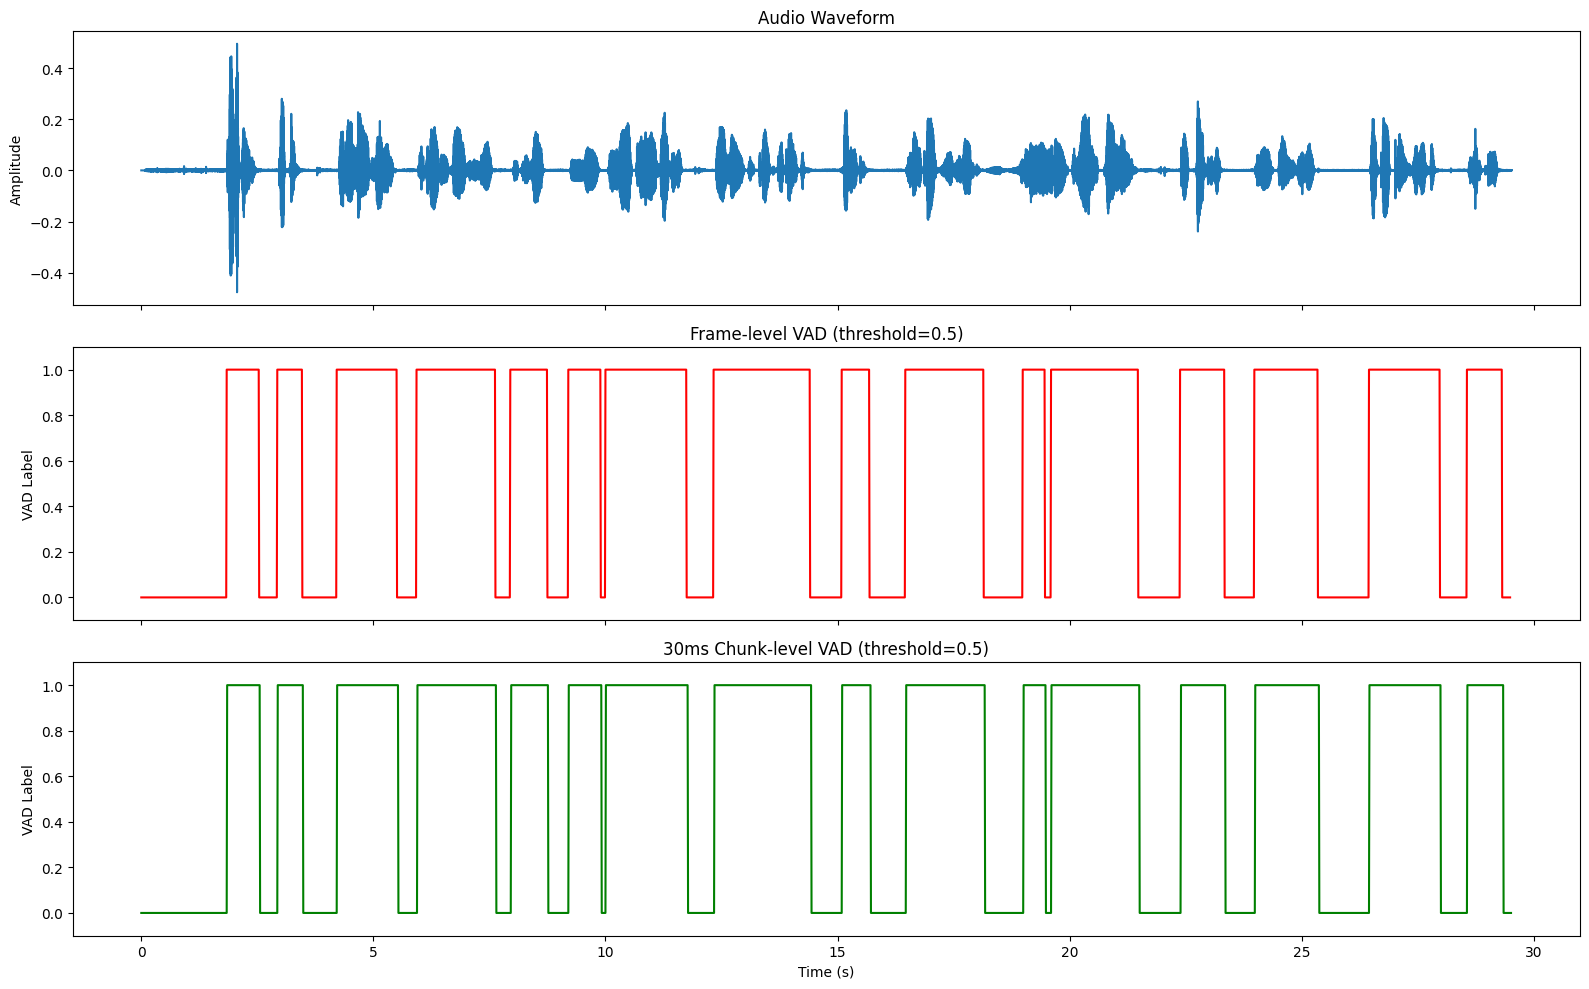

Frame-level speech detected: 63.9% of frames
Chunk-level speech detected: 64.4% of audio
Frame-level speech segments: 16
Chunk-level speech segments: 16


In [12]:
# SileroVAD Frame-Level Debug Tool
import librosa
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from IPython.display import Audio
import torch

from prepare_data import initialize_silero_vad, generate_silero_vad_labels, get_original_path

# Initialize Silero VAD model
model, utils = initialize_silero_vad()
vad_model = (model, utils)

def analyze_silero_vad_30ms_chunks(
    audio_path,
    threshold=0.5,
    sr=16000,
    min_speech_duration_ms=250,
    min_silence_duration_ms=100
):
    """Analyze audio using Silero VAD with 30ms chunks instead of frame-level"""
    
    # Load audio
    audio_path = Path(audio_path)
    original_path = get_original_path(audio_path)
    y, sr = librosa.load(original_path, sr=sr)
    
    # Use 30ms window size (in samples)
    window_size_samples = int(sr * 0.03)  # 30ms
    
    # Ensure model is on CPU to match audio data
    device = next(model.parameters()).device
    model_cpu = model.to('cpu')
    
    # Get speech timestamps using chunk-based processing
    speech_timestamps = utils['get_speech_timestamps'](
        y, 
        model_cpu,  # Use CPU model 
        sampling_rate=sr,
        threshold=threshold,
        min_speech_duration_ms=min_speech_duration_ms,
        min_silence_duration_ms=min_silence_duration_ms,
        window_size_samples=window_size_samples,
        speech_pad_ms=30
    )
    
    # Create visualization
    plt.figure(figsize=(16, 8))
    
    # Plot waveform with speech regions highlighted
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(y)) / sr, y)
    plt.title(f"Audio with Speech Regions (30ms chunks, threshold={threshold})")
    
    # Highlight speech regions
    for ts in speech_timestamps:
        start_time = ts['start'] / sr
        end_time = ts['end'] / sr
        plt.axvspan(start_time, end_time, color='green', alpha=0.3)
    
    plt.ylabel("Amplitude")
    
    # Create binary speech activity representation for lower plot
    chunk_duration = 0.03  # 30ms chunks
    num_chunks = int(np.ceil(len(y) / (sr * chunk_duration)))
    chunk_activity = np.zeros(num_chunks)
    chunk_times = np.arange(num_chunks) * chunk_duration
    
    # Mark chunks with detected speech
    for ts in speech_timestamps:
        start_chunk = ts['start'] // window_size_samples
        end_chunk = ts['end'] // window_size_samples
        chunk_activity[start_chunk:end_chunk+1] = 1
    
    # Plot chunk activity
    plt.subplot(2, 1, 2)
    plt.step(chunk_times, chunk_activity, where='post')
    plt.ylim([-0.1, 1.1])
    plt.title(f"Silero VAD Speech Detection (30ms chunks)")
    plt.ylabel("Speech Detected")
    plt.xlabel("Time (s)")
    
    plt.tight_layout()
    plt.show()
    
    # Display audio for playback
    display(Audio(y, rate=sr))
    
    # Calculate statistics
    total_duration = len(y) / sr
    speech_duration = sum((ts['end'] - ts['start']) / sr for ts in speech_timestamps)
    speech_percentage = (speech_duration / total_duration) * 100
    
    print(f"Audio length: {total_duration:.2f} seconds")
    print(f"Speech detected: {speech_duration:.2f} seconds ({speech_percentage:.1f}%)")
    print(f"Found {len(speech_timestamps)} speech segments:")
    
    # Print each segment details
    for i, ts in enumerate(speech_timestamps):
        start_time = ts['start'] / sr
        end_time = ts['end'] / sr
        duration = end_time - start_time
        print(f"  Segment {i+1}: {start_time:.2f}s - {end_time:.2f}s (duration: {duration:.2f}s)")
    
    # Move model back to its original device
    model_cpu.to(device)
    
    return speech_timestamps

def debug_silero_vad(
    audio_path,
    thresholds=[0.3, 0.5, 0.7],  # Test different threshold values
    hop_length=160,
    win_length=400
):
    """Debug Silero VAD frame-level outputs with different thresholds"""
    
    # Load audio
    audio_path = Path(audio_path)
    original_path = get_original_path(audio_path)
    y, sr = librosa.load(original_path, sr=16000)
    
    # Ensure model is on CPU for processing
    device = next(model.parameters()).device
    model_cpu = model.to('cpu')
    
    # Set up plot
    fig, axes = plt.subplots(len(thresholds) + 1, 1, figsize=(16, 3*(len(thresholds) + 1)), sharex=True)
    
    # Plot waveform
    axes[0].plot(np.arange(len(y)) / sr, y)
    axes[0].set_title("Audio Waveform")
    axes[0].set_ylabel("Amplitude")
    
    # Generate and plot Silero VAD labels with different thresholds
    for i, threshold in enumerate(thresholds):
        # Generate Silero VAD labels
        silero_labels = generate_silero_vad_labels(
            y, sr, model_cpu,
            threshold=threshold,
            hop_length=hop_length,
            win_length=win_length,
            utils=utils
        )
        
        # Plot labels
        vad_times = librosa.frames_to_time(np.arange(len(silero_labels)), sr=sr, hop_length=hop_length)
        axes[i+1].plot(vad_times, silero_labels, 'r')
        axes[i+1].set_ylim([-0.1, 1.1])
        axes[i+1].set_title(f"Silero VAD (threshold={threshold}) → {np.mean(silero_labels)*100:.2f}% active")
        axes[i+1].set_ylabel("VAD Label")
    
    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()
    
    # Display audio for playback
    display(Audio(y, rate=sr))
    
    # Move model back to its original device
    model_cpu.to(device)
    
    return y, sr

def analyze_silero_vad_transitions(
    audio_path,
    threshold=0.5,
    hop_length=160,
    win_length=400,
    context_window_ms=200  # ms of audio to show around transitions
):
    """Analyze Silero VAD transitions in detail"""
    
    # Load audio
    audio_path = Path(audio_path)
    original_path = get_original_path(audio_path)
    y, sr = librosa.load(original_path, sr=16000)
    
    # Ensure model is on CPU for processing
    device = next(model.parameters()).device
    model_cpu = model.to('cpu')
    
    # Generate Silero VAD labels
    silero_labels = generate_silero_vad_labels(
        y, sr, model_cpu,
        threshold=threshold,
        hop_length=hop_length,
        win_length=win_length,
        utils=utils
    )
    
    # Find transitions (0→1 or 1→0)
    transitions = np.diff(np.concatenate(([0], silero_labels, [0])))
    onsets = np.where(transitions == 1)[0]
    offsets = np.where(transitions == -1)[0]
    
    # Convert frame indices to time and samples
    vad_times = librosa.frames_to_time(np.arange(len(silero_labels)), sr=sr, hop_length=hop_length)
    
    # Determine context window size in samples
    context_window_samples = int((context_window_ms / 1000) * sr)
    
    # Plot overall waveform with transitions
    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(len(y)) / sr, y)
    for onset in onsets:
        if onset < len(vad_times):
            plt.axvline(x=vad_times[onset-1], color='g', linestyle='--', alpha=0.7)
    for offset in offsets:
        if offset <= len(vad_times):
            plt.axvline(x=vad_times[offset-1], color='r', linestyle='--', alpha=0.7)
    plt.title("Audio Waveform with VAD Transitions")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    # Plot individual transitions with zoomed-in context
    n_transitions = min(5, len(onsets) + len(offsets))  # Limit to 5 transitions
    
    if n_transitions > 0:
        fig, axes = plt.subplots(n_transitions, 1, figsize=(16, 3*n_transitions))
        if n_transitions == 1:
            axes = [axes]  # Make it iterable when there's only one subplot
            
        transition_points = sorted([(t, "onset") for t in onsets[:n_transitions//2+1]] + 
                                  [(t, "offset") for t in offsets[:n_transitions//2+1]])
        
        for i, (frame_idx, trans_type) in enumerate(transition_points[:n_transitions]):
            if frame_idx <= len(vad_times):
                # Convert frame index to sample index
                sample_idx = int(vad_times[frame_idx-1] * sr)
                
                # Get context window
                start_sample = max(0, sample_idx - context_window_samples)
                end_sample = min(len(y), sample_idx + context_window_samples)
                
                # Plot context window
                context_time = np.arange(start_sample, end_sample) / sr
                axes[i].plot(context_time, y[start_sample:end_sample])
                axes[i].axvline(x=vad_times[frame_idx-1], color='r' if trans_type == "offset" else 'g',
                              linestyle='--', label=f"{trans_type.capitalize()} at {vad_times[frame_idx-1]:.3f}s")
                
                # Add a band showing VAD state
                if frame_idx < len(vad_times):
                    local_frames = np.arange(max(0, frame_idx-20), min(len(silero_labels), frame_idx+20))
                    local_times = vad_times[local_frames]
                    local_labels = silero_labels[local_frames]
                    
                    # Plot VAD labels in context
                    ax2 = axes[i].twinx()
                    ax2.plot(local_times, local_labels, 'r-', alpha=0.5)
                    ax2.set_ylim([-0.1, 1.1])
                    ax2.set_ylabel("VAD State")
                
                axes[i].set_title(f"{trans_type.capitalize()} at {vad_times[frame_idx-1]:.3f}s")
                axes[i].set_ylabel("Amplitude")
                axes[i].legend()
        
        plt.tight_layout()
        plt.show()
    
    # Display audio for playback
    display(Audio(y, rate=sr))
    
    print(f"Found {len(onsets)} speech onsets and {len(offsets)-1} speech offsets")
    
    # Move model back to its original device
    model_cpu.to(device)
    
    return y, sr, silero_labels

def compare_vad_methods(
    audio_path,
    threshold=0.5,
    sr=16000,
    hop_length=160,
    win_length=400
):
    """Compare frame-level vs 30ms chunk-level Silero VAD"""
    
    # Load audio
    audio_path = Path(audio_path)
    original_path = get_original_path(audio_path)
    y, sr = librosa.load(original_path, sr=sr)
    
    # Ensure model is on CPU for processing
    device = next(model.parameters()).device
    model_cpu = model.to('cpu')
    
    # 1. Generate frame-level labels
    frame_labels = generate_silero_vad_labels(
        y, sr, model_cpu,
        threshold=threshold,
        hop_length=hop_length,
        win_length=win_length,
        utils=utils
    )
    
    # 2. Generate 30ms chunk level timestamps
    window_size_samples = int(sr * 0.03)  # 30ms
    chunk_timestamps = utils['get_speech_timestamps'](
        y, 
        model_cpu,
        threshold=threshold,
        sampling_rate=sr,
        window_size_samples=window_size_samples
    )
    
    # Convert chunk timestamps to binary activity
    audio_duration_seconds = len(y) / sr
    # Create frame-aligned binary chunk representation for fair comparison
    chunk_times = np.arange(0, audio_duration_seconds, hop_length/sr)
    chunk_activity = np.zeros(len(chunk_times))
    
    for ts in chunk_timestamps:
        start_time = ts['start'] / sr
        end_time = ts['end'] / sr
        start_idx = int(start_time * sr / hop_length)
        end_idx = min(int(end_time * sr / hop_length), len(chunk_activity)-1)
        chunk_activity[start_idx:end_idx+1] = 1
    
    # Visualization
    fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
    
    # 1. Waveform
    axes[0].plot(np.arange(len(y)) / sr, y)
    axes[0].set_title("Audio Waveform")
    axes[0].set_ylabel("Amplitude")
    
    # 2. Frame-level VAD
    frame_times = librosa.frames_to_time(np.arange(len(frame_labels)), sr=sr, hop_length=hop_length)
    axes[1].plot(frame_times, frame_labels, 'r')
    axes[1].set_ylim([-0.1, 1.1])
    axes[1].set_title(f"Frame-level VAD (threshold={threshold})")
    axes[1].set_ylabel("VAD Label")
    
    # 3. 30ms Chunk-level VAD 
    axes[2].plot(chunk_times[:len(chunk_activity)], chunk_activity, 'g')
    axes[2].set_ylim([-0.1, 1.1])
    axes[2].set_title(f"30ms Chunk-level VAD (threshold={threshold})")
    axes[2].set_ylabel("VAD Label")
    axes[2].set_xlabel("Time (s)")
    
    plt.tight_layout()
    plt.show()
    
    # Display audio for playback
    display(Audio(y, rate=sr))
    
    # Calculate statistics
    frame_speech_percentage = np.mean(frame_labels) * 100
    chunk_speech_percentage = np.mean(chunk_activity) * 100
    
    print(f"Frame-level speech detected: {frame_speech_percentage:.1f}% of frames")
    print(f"Chunk-level speech detected: {chunk_speech_percentage:.1f}% of audio")
    print(f"Frame-level speech segments: {len(np.where(np.diff(np.concatenate(([0], frame_labels, [0]))) == 1)[0])}")
    print(f"Chunk-level speech segments: {len(chunk_timestamps)}")
    
    # Move model back to its original device
    model_cpu.to(device)
    
    return frame_labels, chunk_timestamps

# Example usage with the same file
audio_path = "D:/belajar/audio/vad/datasets/fleurs_speech/yo_ng_000238.wav" 

# Analyze using 30ms chunks
speech_segments = analyze_silero_vad_30ms_chunks(
    audio_path,
    threshold=0.5,
    min_speech_duration_ms=250
)

# Compare frame-level vs chunk-level approaches
frame_labels, chunk_timestamps = compare_vad_methods(audio_path, threshold=0.5)

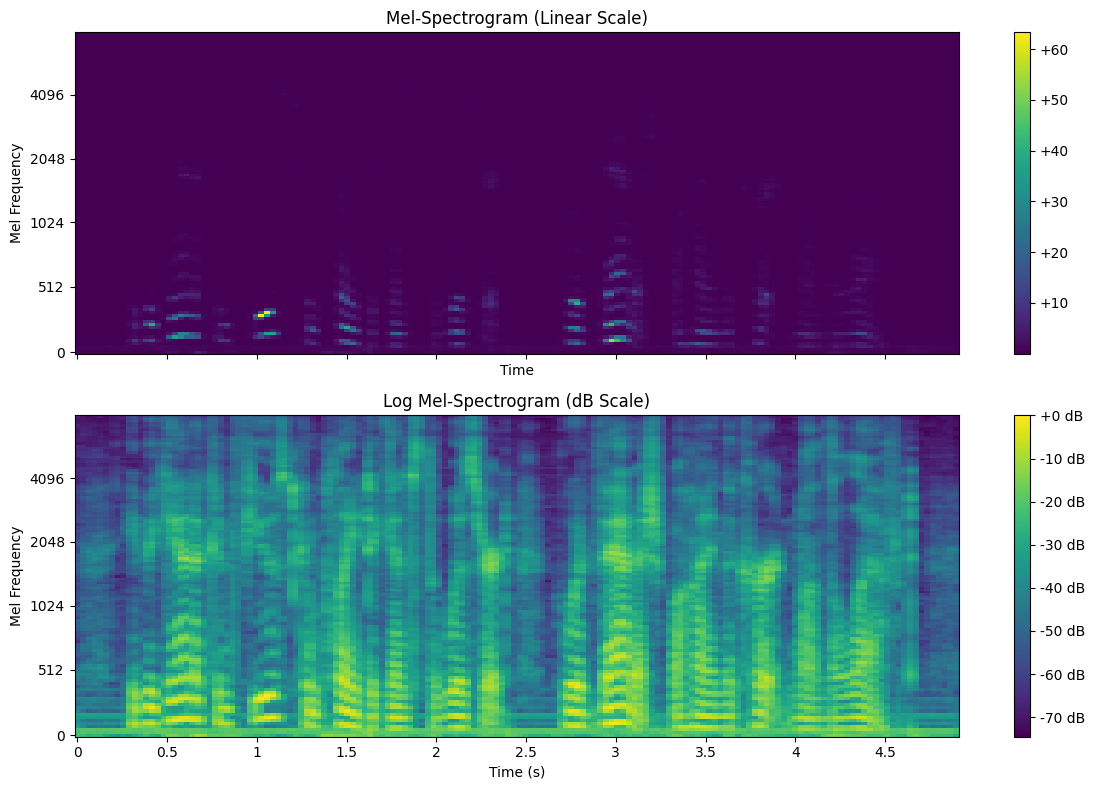

Mel-spectrogram shape: (128, 154)
Linear scale range: [0.00, 63.33]
Log scale range: [-74.53, 0.00] dB


In [5]:

import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Load audio file
audio_path = "D:/belajar/audio/vad/datasets/LibriSpeech/test-clean/61/70968/61-70968-0000.flac"
y, sr = librosa.load(audio_path, sr=None)

# Compute STFT
S = librosa.stft(y)
D = np.abs(S)**2  # Power spectrogram

# Compute mel-spectrogram (linear scale)
mel_spec = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=128)

# Compute log mel-spectrogram (log scale)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot mel-spectrogram
img1 = librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', 
                sr=sr, ax=axes[0], cmap='viridis')
axes[0].set_title('Mel-Spectrogram (Linear Scale)')
axes[0].set_ylabel('Mel Frequency')
fig.colorbar(img1, ax=axes[0], format='%+2.0f')

# Plot log mel-spectrogram
img2 = librosa.display.specshow(log_mel_spec, x_axis='time', y_axis='mel', 
                sr=sr, ax=axes[1], cmap='viridis')
axes[1].set_title('Log Mel-Spectrogram (dB Scale)')
axes[1].set_ylabel('Mel Frequency')
axes[1].set_xlabel('Time (s)')
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Print some information about the spectrograms
print(f"Mel-spectrogram shape: {mel_spec.shape}")
print(f"Linear scale range: [{mel_spec.min():.2f}, {mel_spec.max():.2f}]")
print(f"Log scale range: [{log_mel_spec.min():.2f}, {log_mel_spec.max():.2f}] dB")